### Tutorial on LSTM seq2seq model, with / without Attention

Following <https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb>

This examples serves as "toy problem" to test the current Docker image *py-da-tf*.

NOTE: Works, but training is *really, really* slow! Needs improvement!

In [2]:
# import libraries
import random
import numpy as np
import matplotlib.pyplot as plt

import os as os
import pickle as pkl
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, Conv1D, LeakyReLU, \
    multiply, concatenate, Flatten, Activation, dot, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

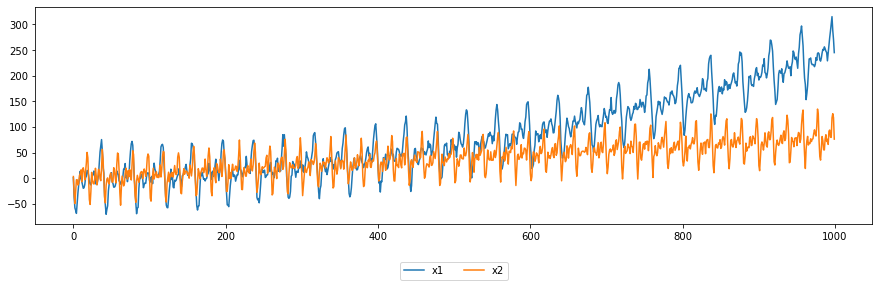

800
[ 2.43347552e-04  7.28628471e-03 -2.08568027e+00]
[ 0.08108349 -0.93427987]


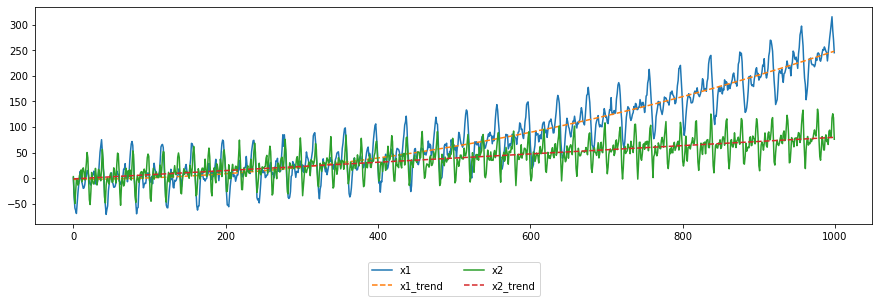

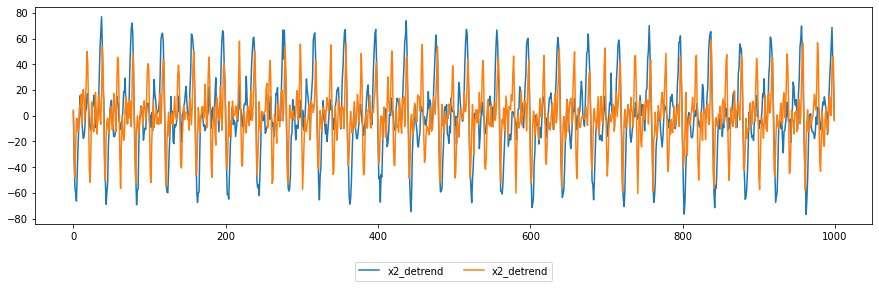

(1000, 4)
[[  3.20669758   4.36919194   0.           1.        ]
 [-33.99024537 -29.29372487   1.           1.        ]
 [-55.59614418 -48.28017849   2.           1.        ]
 ...
 [ 41.52789699  46.1208141  997.           0.        ]
 [ 23.05681307  38.18391414 998.           0.        ]
 [ -2.95028229  -3.7136177  999.           0.        ]]
[76.98213088850186, 57.92831847300712, 1, 1]
[[ 4.16550899e-02  7.54241113e-02  0.00000000e+00  1.00000000e+00]
 [-4.41534223e-01 -5.05689197e-01  1.00000000e+00  1.00000000e+00]
 [-7.22195444e-01 -8.33446918e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 5.39448525e-01  7.96170428e-01  9.97000000e+02  0.00000000e+00]
 [ 2.99508637e-01  6.59157993e-01  9.98000000e+02  0.00000000e+00]
 [-3.83242481e-02 -6.41071207e-02  9.99000000e+02  0.00000000e+00]]


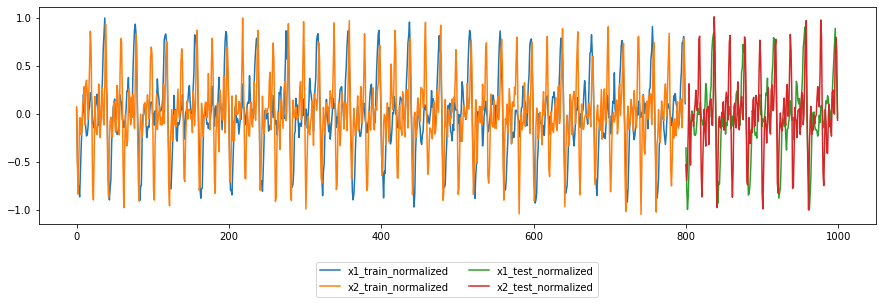

(781, 200, 3) (781, 20, 3) (781,)
(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


In [3]:
# create some data
n_ = 1000
t = np.linspace(0, 50*np.pi, n_) # linspace(start, stop, number of steps)
np.shape(t)
t[:21]

# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# preprocessing
# split data 80:20 train:test
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

# de-trending time-series using polynomial fit
x_index = np.array(range(len(t)))
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# combine sequences x1 and x2 (first 2 cols), index (3rd col) and label train (0) / test (1) (4th col)
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

# normalization (divide by series max)
# this leads to inputs in range about [-1,+1]
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# truncate series: 200 input and 20 output steps
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

In [4]:
###########################################
# model 1: seq2seq LSTM without Attention #
###########################################

# input layer
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

# encoder LSTM
# 'elu' activation means exponential linear unit
n_hidden = 100
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

# add batch normalization
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# initialize decoder
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

# output
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

# setup model
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

# plot model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# train model
epc = 50
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

# evaluation
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


2022-01-29 19:21:56.731104: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)   

2022-01-29 19:21:58.094701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-29 19:21:58.109885: W tensorflow/core/platform/profile_utils/cpu_utils.cc:116] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency


Epoch 1/50
5/5 [==============================] - 77s 13s/step - loss: 7.0677 - mae: 1.1128 - val_loss: 0.1528 - val_mae: 0.2860
Epoch 2/50
4/5 [=======================>......] - ETA: 11s - loss: 0.5236 - mae: 0.4928

KeyboardInterrupt: 